# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 
airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
balcony — число балконов
ceiling_height — высота потолков (м)
cityCenters_nearest — расстояние до центра города (м)
days_exposition — сколько дней было размещено объявление (от публикации до снятия)
first_day_exposition — дата публикации
floor — этаж
floors_total — всего этажей в доме
is_apartment — апартаменты (булев тип)
kitchen_area — площадь кухни в квадратных метрах (м²)
last_price — цена на момент снятия с публикации
living_area — жилая площадь в квадратных метрах(м²)
locality_name — название населённого пункта
open_plan — свободная планировка (булев тип)
parks_around3000 — число парков в радиусе 3 км
parks_nearest — расстояние до ближайшего парка (м)
ponds_around3000 — число водоёмов в радиусе 3 км
ponds_nearest — расстояние до ближайшего водоёма (м)
rooms — число комнат
studio — квартира-студия (булев тип)
total_area — площадь квартиры в квадратных метрах (м²)
total_images — число фотографий квартиры в объявлении

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
apartment_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
#apartment_data.describe() 
#print(apartment_data)
apartment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

### Шаг 2. Предобработка данных

In [2]:

print(apartment_data['is_apartment'].value_counts())#Проверяем значения столбца
apartment_data['is_apartment'] = apartment_data['is_apartment'].fillna(value = False)# меняем пропущенные значения на false
apartment_data['is_apartment'] = apartment_data['is_apartment'].astype('bool')# меняем тип данных на булев
#print(apartment_data['is_apartment'].value_counts()) #проверяем, что NaN заменены на False

apartment_data['first_day_exposition'] = pd.to_datetime(apartment_data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S') 
apartment_data ['balcony'] = apartment_data ['balcony'].fillna(value = 0) #меняем по заданию NaN в столбце balcony на 0
#print(apartment_data ['balcony'].value_counts())
kitchen_ratio = (apartment_data['total_area'] / apartment_data['kitchen_area']).mean()#считаем коээфециент отношения общей площади к полощади кухни
apartment_data['kitchen_area'] = apartment_data['kitchen_area'].fillna(value = apartment_data['total_area'] / kitchen_ratio)#заполняем пропуски

height_to_median = apartment_data.groupby("floors_total")["ceiling_height"].median().to_dict()
 
def filler(row):
    if np.isnan(row["ceiling_height"]):
        return height_to_median.get(row["floors_total"])
    return row["ceiling_height"]
 
apartment_data["ceiling_height"] = apartment_data.apply(filler, axis=1)


False    2725
True       50
Name: is_apartment, dtype: int64


Обращаем внимание на то, что столбец 'is_apartment' имеет тип данных object, хотя в описании фигурирует булев тип.
проверяем значения столбца, видим что значение True у 50 квартир
False - у 2725 квартир, остальные имеют значение NaN. Поскольку апартаменты - относительно редкое явление,
принимаем, что значения NaN скрывают за собой False. Наблюдаем, что значения в столбце first_day_exposition в формате object, хотя это дата, переводим в формат даты. Меняем пропущенные значения по балконам на 0. Заполнили пропущенные значения в площади кухни с помощью коэффециента отношения общей площади к площади кухни.

### Шаг 3. Посчитайте и добавьте в таблицу

In [3]:
apartment_data ['price_per_sqm'] = apartment_data ['last_price'] / apartment_data ['total_area'] #добавляем столбец со значение цены
#за квадратный метр
apartment_data['weekday'] = apartment_data['first_day_exposition'].dt.weekday
apartment_data['month'] = apartment_data['first_day_exposition'].dt.month
apartment_data['year'] = apartment_data['first_day_exposition'].dt.year #добавляем столбцы с днем недели, месяцем и годом.

def floor_type(row): #создаем функцию для определния типа этажа
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'Первый'
    if floor == floors_total:
        return 'Последний'
    else:
        return 'Другой'
apartment_data['floor_type'] = apartment_data.apply(floor_type, axis = 1)
apartment_data['living_area_ratio'] = apartment_data['living_area'] / apartment_data['total_area'] #считаем значение отношения жилой площади к общей
apartment_data['kitchen_area_ratio'] = apartment_data['kitchen_area'] / apartment_data['total_area'] #считаем значения отношения кухни к общей площади
apartment_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 29 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23621 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            23699 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_ar

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

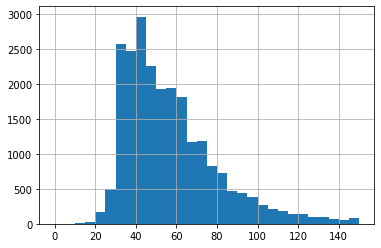

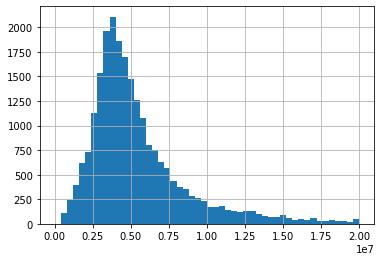

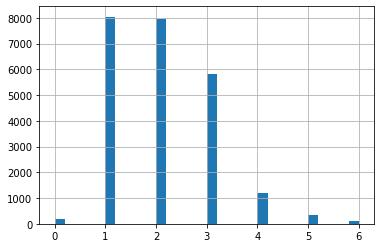

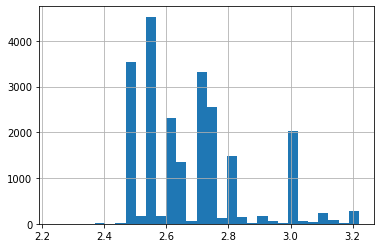

In [4]:
#apartment_data.boxplot(column = 'total_area') # наблюдаем, что значения выше 150 кв.м. можно счтитать выбросами
apartment_data['total_area'].hist(range = (0,150), bins = 30) #для наглядности ограничиваем площадь 150 кв.м.
plt.show()
#apartment_data.boxplot(column = 'last_price') #наблюдаем, что значения выше 20 млн  можно счтитать выбросам
apartment_data['last_price'].hist(range = (0,20000000), bins = 50)#для наглядности ограничиваем цену 20 млн
plt.show()
#apartment_data.boxplot(column = 'rooms')#  наблюдаем, что значения выше 6 комнат можно счтитать выбросами
apartment_data['rooms'].hist( range = (0,6), bins = 30)#ограничеваем гистограмму 6ю комнатами для наглядности
plt.show()
apartment_data['ceiling_height'].describe() #наблюдаем, что значения ниже 2.24 м и выше 3,22 м  можно счтитать выбросом.
apartment_data['ceiling_height'].hist( range = (2.24, 3.22), bins = 30)
plt.show()



Построили гистограммы для отдельных параметров квартир. Для вычисления выбросов используем ящик с усами и метод describe и создаем гистограммы без выбросов.

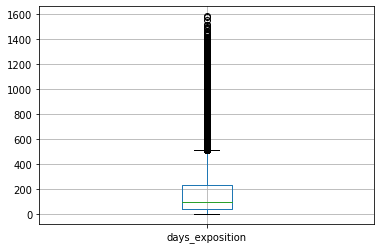

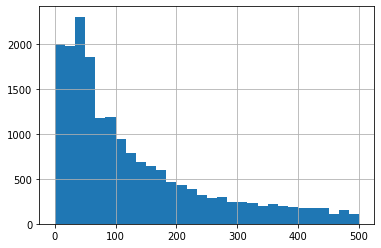

9.0

In [5]:
apartment_data.boxplot(column = 'days_exposition')#наблюдаем, что значения  выше 500 дней можно счтитать выбросом.
plt.show()
apartment_data['days_exposition'].hist( range = (0, 500), bins = 30)
plt.show()
apartment_data['days_exposition'].describe()# среднее время продажи состаляет 181 день, медианное - 95 дней.
apartment_data['days_exposition'].quantile(0.05)#принимаем, что продажа быстрее, чем за 9 дней необычайно быстрая, свыше 500 дней - долгая


С помощью ящика с усами и метода describe находим, что значения выше 500 дней продажи являются аномально долгими, а 5% самых быстрых значений умещаются в 9 дней, соответственно 9 дней явлется аномально коротким сроком продажи.

In [6]:

apartment_data_good = apartment_data.query('days_exposition < 500 & ceiling_height < 3.22 & ceiling_height > 2.24 & rooms > 0 & rooms <= 6 & last_price < 20000000 & total_area <=150')
#создаем срез данных без редких и выбивающихся значений
floor_type_data_mean = apartment_data_good.pivot_table(index='floor_type', values='last_price', aggfunc = 'mean')#создаем сводную таблицу со 
#средними значениями цены для типа этажей
floor_type_data_median = apartment_data_good.pivot_table(index='floor_type', values='last_price', aggfunc = 'median')#создаем сводную таблицу со 
#медианными значениями цены для типа этажей
print(floor_type_data_mean)
print(floor_type_data_median)
weekday_data = apartment_data_good.pivot_table(index='weekday', values='last_price', aggfunc = 'median')
print(weekday_data) 
month_data = apartment_data_good.pivot_table(index='month', values='last_price', aggfunc = 'median')
print(month_data) 
year_data = apartment_data_good.pivot_table(index='year', values='last_price', aggfunc = 'median')
print(year_data)
print(apartment_data_good['last_price'].corr(apartment_data_good['total_area']))
print(apartment_data_good['last_price'].corr(apartment_data_good['rooms']))
print(apartment_data_good['last_price'].corr(apartment_data_good['cityCenters_nearest']))
print(apartment_data_good.corr())




              last_price
floor_type              
Другой      5.284580e+06
Первый      4.080556e+06
Последний   4.673444e+06
            last_price
floor_type            
Другой       4550000.0
Первый       3700000.0
Последний    4003000.0
         last_price
weekday            
0         4390000.0
1         4400000.0
2         4400000.0
3         4400000.0
4         4350000.0
5         4400000.0
6         4300000.0
       last_price
month            
1       4400000.0
2       4395000.0
3       4310000.0
4       4450000.0
5       4350000.0
6       4200000.0
7       4350000.0
8       4450000.0
9       4500000.0
10      4400000.0
11      4500000.0
12      4350000.0
      last_price
year            
2015   4500000.0
2016   4300000.0
2017   4300000.0
2018   4400000.0
2019   4700000.0
0.7467987229163774
0.46343417598198167
-0.33491367750416756
                     total_images  last_price  total_area     rooms  \
total_images             1.000000    0.158603    0.107803  0.075956   
last_pr

Очищаем данные от выбивающихся значений, найденных ранее. С помощью сводных таблиц находим, что у последних и особенно первых этажей цена за квартиру ниже. Также находим, что цена квартир в целом не меняется по дням неделям, но самые дешевые выставляют  по пятницам и воскресеньям. По месяцам самые дорогие квартиры выкладывают в сентябрь и ноябрь , самые дешевые - в июнь. По годам самые дорогие квартиры были выложены в 2019 году самые дешевые - в 2017 году. С помощью метода corr подтверждаем очевидное, что площадь и количество комнат влияют на стоимость положительно, расстояние от центра - отрицательно.

In [7]:
print(apartment_data_good['locality_name'].value_counts().head(10)) #находим топ-10 населенных пунктов по количеству объявлений
st_peterburg_data = apartment_data_good.query('locality_name == "Санкт-Петербург"')
print('Средняя стоимость квадратного метра в Санкт- Петербурге:', int(st_peterburg_data['price_per_sqm'].mean()),'рублей')
vsevolojsk_data = apartment_data_good.query('locality_name == "Всеволожск"')
print('Средняя стоимость квадратного метра во Всеволожске:', int(vsevolojsk_data['price_per_sqm'].mean()),'рублей')
murino_data = apartment_data_good.query('locality_name == "посёлок Мурино"')
print('Средняя стоимость квадратного метра в поселке Мурино:', int(murino_data['price_per_sqm'].mean()),'рублей')
shushari_data = apartment_data_good.query('locality_name == "посёлок Шушары"')
print('Средняя стоимость квадратного метра в поселке Шушары:', int(shushari_data['price_per_sqm'].mean()),'рублей')
kolpino_data = apartment_data_good.query('locality_name == "Колпино"')
print('Средняя стоимость квадратного метра в Колпине:', int(kolpino_data['price_per_sqm'].mean()),'рублей')
pushkin_data = apartment_data_good.query('locality_name == "Пушкин"')
print('Средняя стоимость квадратного метра в Пушкине:', int(pushkin_data['price_per_sqm'].mean()),'рублей')
pargolovo_data = apartment_data_good.query('locality_name == "посёлок Парголово"')
print('Средняя стоимость квадратного метра в поселке Парголово:', int(pargolovo_data['price_per_sqm'].mean()),'рублей')
gatchina_data = apartment_data_good.query('locality_name == "Гатчина"')
print('Средняя стоимость квадратного метра в Гатчине:', int(gatchina_data['price_per_sqm'].mean()),'рублей')
petergof_data = apartment_data_good.query('locality_name == "Петергоф"')
print('Средняя стоимость квадратного метра в Петергофе:', int(petergof_data['price_per_sqm'].mean()),'рублей')
kudrovo_data = apartment_data_good.query('locality_name == "деревня Кудрово"')
print('Средняя стоимость квадратного метра в деревне Кудрово:', int(kudrovo_data['price_per_sqm'].mean()),'рублей')


Санкт-Петербург      11416
посёлок Мурино         457
посёлок Шушары         380
Всеволожск             299
Колпино                290
посёлок Парголово      282
Пушкин                 265
деревня Кудрово        251
Гатчина                242
Выборг                 186
Name: locality_name, dtype: int64
Средняя стоимость квадратного метра в Санкт- Петербурге: 106578 рублей
Средняя стоимость квадратного метра во Всеволожске: 66567 рублей
Средняя стоимость квадратного метра в поселке Мурино: 85372 рублей
Средняя стоимость квадратного метра в поселке Шушары: 77591 рублей
Средняя стоимость квадратного метра в Колпине: 74682 рублей
Средняя стоимость квадратного метра в Пушкине: 100474 рублей
Средняя стоимость квадратного метра в поселке Парголово: 89479 рублей
Средняя стоимость квадратного метра в Гатчине: 68029 рублей
Средняя стоимость квадратного метра в Петергофе: 82688 рублей
Средняя стоимость квадратного метра в деревне Кудрово: 92426 рублей


Находим топ-10 населенных пунктов по количеству объявлений, рассчитываем среднюю стоимость квадратного метра для каждого из них. Самые дорогие квадратные метры в Петербурге, Пушкине и Кудрове. Самые дешевые - во Всеволожске, Гатчине и Колпине.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Корреляция между ценой и площадью в центре 0.6737838099747164
Корреляция между ценой и количеством комнат в центре 0.41753677033309167
Корреляция между ценой и расстоянием от центра в центре города -0.07671128243372052
Корреляция между ценой и площадью в общем 0.7467987229163774
Корреляция между ценой и количеством комнат в общем 0.46343417598198167
Корреляция между ценой и расстоянием от центра в общем -0.33491367750416756


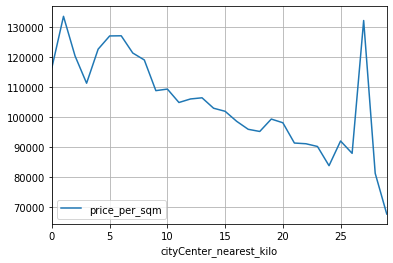

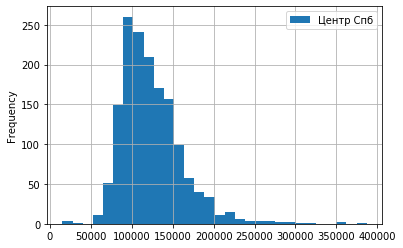

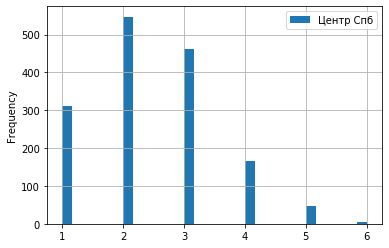

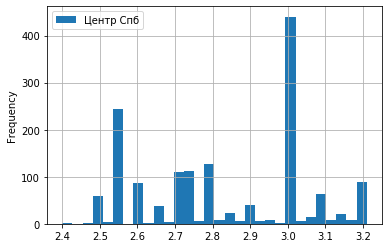

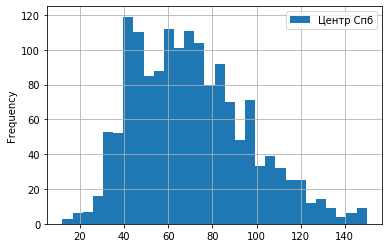

In [8]:
st_peterburg_data['cityCenter_nearest_kilo'] = round(st_peterburg_data['cityCenters_nearest'] / 1000, 0)#считаем расстояние до цетнра в километрах
mean_price_sqm_kilo_data = st_peterburg_data.pivot_table(index='cityCenter_nearest_kilo', values='price_per_sqm', aggfunc = 'mean')
mean_price_sqm_kilo_data.plot(y='price_per_sqm', kind='line', grid = True) #строим график средних цен за квадратный метр в зависимости от расстояния от центра
#цена начинает падать после 7 км от центра.
st_peterburg_data_centre = st_peterburg_data.query('cityCenter_nearest_kilo < 7')
#print(st_peterburg_data_centre)

st_peterburg_data_centre_hist = st_peterburg_data_centre[['price_per_sqm','rooms','ceiling_height','total_area']]
for column in st_peterburg_data_centre_hist:
    st_peterburg_data_centre_hist.plot(y= column, kind='hist', bins=30, linewidth=5, 
                     grid=True, legend=True, label = 'Центр Спб') 
print('Корреляция между ценой и площадью в центре', st_peterburg_data_centre['last_price'].corr(st_peterburg_data_centre['total_area']))
print('Корреляция между ценой и количеством комнат в центре', st_peterburg_data_centre['last_price'].corr(st_peterburg_data_centre['rooms']))
print('Корреляция между ценой и расстоянием от центра в центре города', st_peterburg_data_centre['last_price'].corr(st_peterburg_data_centre['cityCenter_nearest_kilo']))
print('Корреляция между ценой и площадью в общем', apartment_data_good['last_price'].corr(apartment_data_good['total_area']))
print('Корреляция между ценой и количеством комнат в общем', apartment_data_good['last_price'].corr(apartment_data_good['rooms']))
print('Корреляция между ценой и расстоянием от центра в общем', apartment_data_good['last_price'].corr(apartment_data_good['cityCenters_nearest']))


Для начала округляем значения расстояний от центра с точностью до километра. Строим график зависмости цены за квадратный метр от расстония от центра, кроме выброса в районе 25 километров (скорее всего элитный загородный поселок), наблдаем что цены начинают падать после 7 км. Это значение и считаем за центр. Анализируем данные по центру Петербурга. По данным о высоте потолка наблюдаем, что в целом по городу преобладает значение в 2,5м, то в центре Питера 3,0 м. Если по городу в целом пик значений по общей площади находится в пределах 30 -60 кв.м, то в центре Питера - 40 и 60-80 кв.м. По количеству комнат в целом по городу количество однокомнатных и двукомнатных квартир примерно одинково, но в центре однокомнатные квартиры встречатся реже чем дву- и даже трехкомнатные. По поводу зависимости цены от таких параметров, как: площадь, количество комнат и расстоянием от центра, квартиры в центре меньше подвержены изменению цены, чем квартиры в целом по городу.

### Шаг 5. Общий вывод

Был проведен визуальный анализ данных, срезаны выбросы, заменены или удалены пропущенные значения, построены графики по разным параметрам. Проанализовали корреляцию цены и различных параметров, посчитана средняя цена квадратного метра по топ-10 населенным пунктам Санкт-Петербурга, определен центр города. Проведен сравнительный анализ корреляции цен с различными параметрами между центром города и города в целом.